In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [3]:
import scipy.stats as stats

def check_significance(model1_accuracies, model2_accuracies, alpha=0.05, paired=True):
    """
    Checks if the difference in accuracies between two models is statistically significant.

    Args:
        model1_accuracies (list): Accuracies for Model 1 across runs.
        model2_accuracies (list): Accuracies for Model 2 across runs.
        alpha (float): Significance level (default is 0.05).
        paired (bool): Whether to use a paired t-test (default is True). If False, uses an independent t-test.

    Returns:
        bool: True if the difference is statistically significant, False otherwise.
    """
    min_len = min(len(model1_accuracies), len(model2_accuracies))
    if paired:
        # Paired t-test for dependent samples
        _, p_value = stats.ttest_rel(model1_accuracies[:min_len], model2_accuracies[:min_len])
    else:
        # Independent t-test for independent samples
        _, p_value = stats.ttest_ind(model1_accuracies[:min_len], model2_accuracies[:min_len])

    return p_value < alpha

def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


## Chapter 4: CEMs

In [4]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 15)
MAIN_METHOD = "MixCEM Final All Sample"

color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (Platt Calibrated)": "red",
    "MixCEM (No Calibration)": "gray",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
    "Logit Joint CBM": "salmon",
    "Independent CBM": "lightgreen",
    "Sequential CBM": "slateblue",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
    "Sequential CBM",
    "Independent CBM",
    "Logit Joint CBM",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Sigmoidal Joint CBM": '-o',
    "Logit Joint CBM": '-v',
    "Sequential CBM": '-^',
    "Independent CBM": '-2',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (Platt Calibrated)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    MAIN_METHOD: "MixCEM (ours)",
    MAIN_METHOD + " No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final All No Sample": "MixCEM (No test-time sampling)",
    "MixCEM Final Sample No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final Sample": "MixCEM (Platt Calibrated)",
    "MixCEM Final": "MixCEM (ours)",
    "MixCEM Final All": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

In [5]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_completeness_ablation/',
        name='CUB',
        n_concepts=112,
        n_groups=28,
    ),
]
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** CUB ****************************************
	For DNN we selected: DNN (Baseline)
	For Joint CBM we selected: Joint CBM (Baseline)
	For Hybrid-CBM we selected: Hybrid-CBM (Baseline)
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM (Baseline)
	For Posthoc CBM we selected: Posthoc CBM (Baseline)
	For Posthoc Hybrid CBM we selected: Posthoc Hybrid CBM (Baseline)
	For CEM we selected: CEM (Baseline)
	For IntCEM we selected: IntCEM (Baseline)
	For MixCEM Final All Sample we selected: MixCEM Final All Sample (Baseline)


model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got means [18.78667587 47.19537453 63.1170176  67.19882637 67.94960304 70.66793234]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got means [16.81912323 43.3897135  55.13462202 59.86365205 61.34794615 61.43424232]


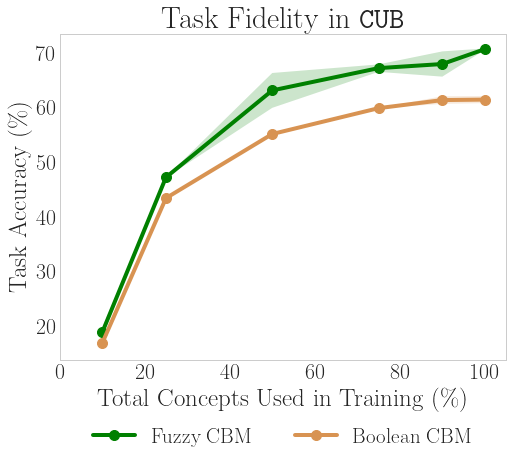

In [33]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM'),
]
color_map['Fuzzy CBM'] = 'green'
color_map['Boolean CBM'] = '#d89352' #'brown'
for idx, (model_name_template, label) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    label = rename_map.get(label, label)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=10,
        linewidth=4,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got means [85.58878379 85.28780972 87.04174947 85.83337306 85.99552674 86.8170127 ]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got means [84.92539283 86.20486455 86.77542014 86.3670102  86.36751333 86.28512405]


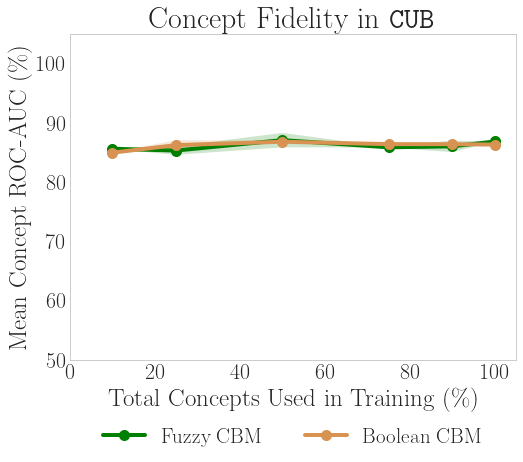

In [34]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM'),
]
color_map['Fuzzy CBM'] = 'green'
color_map['Boolean CBM'] = '#d89352' #'brown'
for idx, (model_name_template, label) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    label = rename_map.get(label, label)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=10,
        linewidth=4,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 105)
ax.set_ylabel("Mean Concept ROC-AUC (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Concept Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_concept{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_concept{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.70607525 0.69520193]
 [0.71211598 0.71211598]
 [0.72937522 0.71971004]
 [0.71332413 0.72281671]
 [0.72333448 0.71971004]
 [0.72178115 0.72229893]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [70.06385916 71.21159821 72.45426303 71.80704177 72.15222644 72.20400414]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

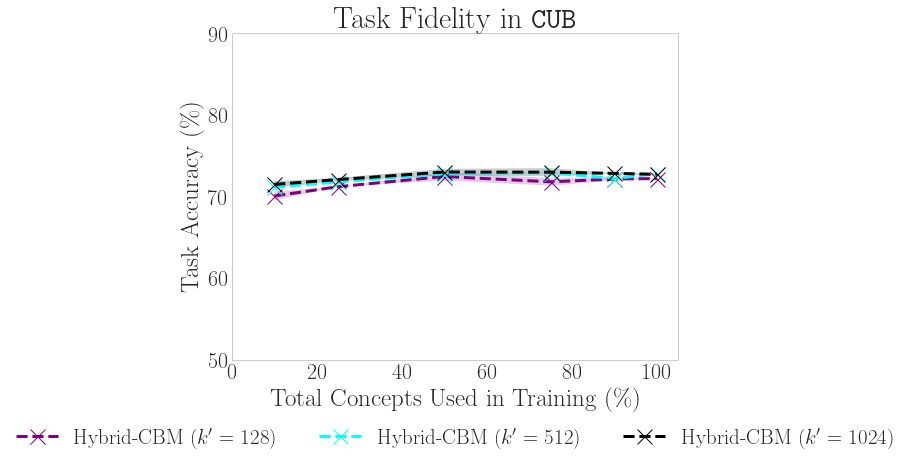

In [49]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 90)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_task_hybrid_cbms{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_task_hybrid_cbms{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.87287004 0.86966686]
 [0.88453439 0.88290284]
 [0.87979136 0.87850945]
 [0.85922447 0.86438434]
 [0.86515003 0.8620517 ]
 [0.86021531 0.86754122]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [87.12684497 88.37186139 87.91504041 86.18044051 86.36008625 86.38782661]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

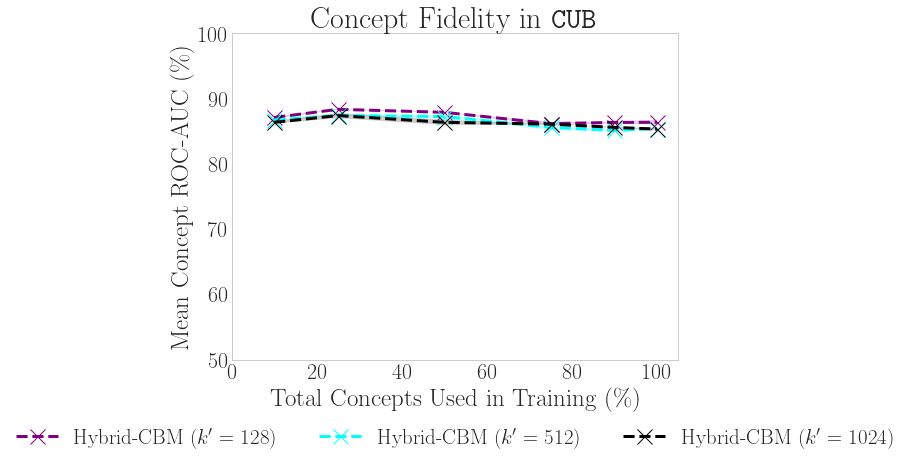

In [76]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_ylabel("Mean Concept ROC-AUC (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Concept Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_concept_hybrid_cbms{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_concept_hybrid_cbms{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.72937522 0.73144632 0.73334484 0.73610632 0.7386952  0.74145668
  0.74352779 0.7454263  0.74715223 0.74905074 0.75284777 0.75509147
  0.7566448  0.75940628 0.76268554 0.76423887 0.76561961 0.76769071
  0.76907145 0.77217812 0.77511219 0.77735589 0.77908181 0.78132551
  0.78581291 0.78719365 0.78960994 0.79116327 0.79444253 0.79599586
  0.79772178 0.80048326 0.80272696 0.80617881 0.81014843 0.81204695
  0.81411805 0.81618916 0.81964101 0.82188471 0.82412841 0.82688989
  0.82965136 0.8310321  0.8332758  0.8355195  0.83724543 0.8400069
  0.84397653 0.84535727 0.84829134 0.85036244 0.85312392 0.85502244
  0.85726614 0.85864688 0.85933725]
 [0.71971004 0.72143597 0.72488781 0.72695892 0.7297204  0.73299965
  0.73541595 0.73731446 0.73852261 0.74111149 0.74352779 0.74663445
  0.74922333 0.75181222 0.7544011  0.7566448  0.7590611  0.76199517
  0.76423887 0.76751812 0.76924405 0.77062478 0.77304108 0.77511219
  0.77666552 0.78011736 0.78236106 

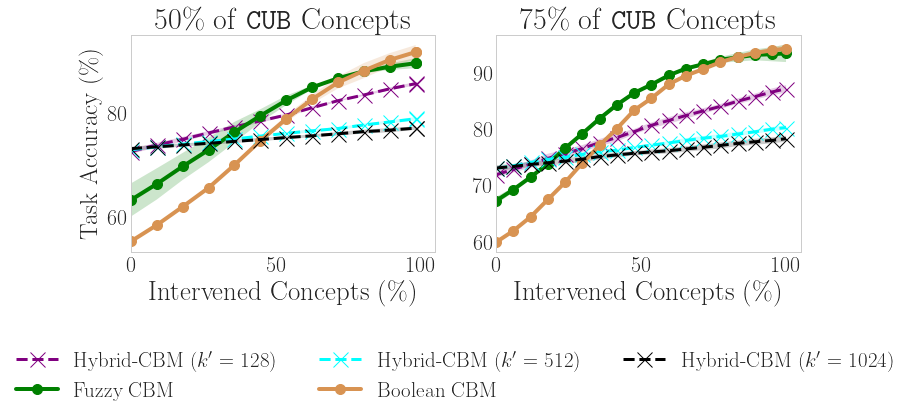

In [74]:
rc('text', usetex=True) # For quality, let's temporarily disable this
sampling_percents = [0.5, 0.75]
fig, axs = plt.subplots(1, len(sampling_percents), figsize=(12, 4), squeeze=False)
results = results_to_include[0]['results']
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for axis_idx, sampling_percent in enumerate(sampling_percents):
    ax = axs[0, axis_idx]
    for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        vals = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_False_use_prior_False_ints",
        )
        vals = np.array(vals)
        print("For", label, "we got vals", vals)
        print(vals.shape)
        means = np.mean(vals, axis=0) * 100
        print("For", label, "we got means", means)
        stds = np.std(vals, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if color is None:
            color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        linestyle = '-'
        xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
        means = np.array(list(means[::freq]) + [means[-1]])
        stds = np.array(list(stds[::freq]) + [stds[-1]])
        marker = markers.get(label, "x" if "Hybrid" in label else "o")
        linestyle = '--' if "Hybrid" in label else '-'
        linewidth = 3 if "Hybrid" in label else 4 
        markersize = 15 if "Hybrid" in label else 10 
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=markersize,
            linewidth=linewidth,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    # ax.set_ylim(50, 90)
    if axis_idx == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -3)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title(str(int(sampling_percent * 100)) + r"\% of \texttt{CUB} Concepts", fontsize=30)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=3, #len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_interventions_larger{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_interventions_larger{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.72937522 0.73144632 0.73334484 0.73610632 0.7386952  0.74145668
  0.74352779 0.7454263  0.74715223 0.74905074 0.75284777 0.75509147
  0.7566448  0.75940628 0.76268554 0.76423887 0.76561961 0.76769071
  0.76907145 0.77217812 0.77511219 0.77735589 0.77908181 0.78132551
  0.78581291 0.78719365 0.78960994 0.79116327 0.79444253 0.79599586
  0.79772178 0.80048326 0.80272696 0.80617881 0.81014843 0.81204695
  0.81411805 0.81618916 0.81964101 0.82188471 0.82412841 0.82688989
  0.82965136 0.8310321  0.8332758  0.8355195  0.83724543 0.8400069
  0.84397653 0.84535727 0.84829134 0.85036244 0.85312392 0.85502244
  0.85726614 0.85864688 0.85933725]
 [0.71971004 0.72143597 0.72488781 0.72695892 0.7297204  0.73299965
  0.73541595 0.73731446 0.73852261 0.74111149 0.74352779 0.74663445
  0.74922333 0.75181222 0.7544011  0.7566448  0.7590611  0.76199517
  0.76423887 0.76751812 0.76924405 0.77062478 0.77304108 0.77511219
  0.77666552 0.78011736 0.78236106 

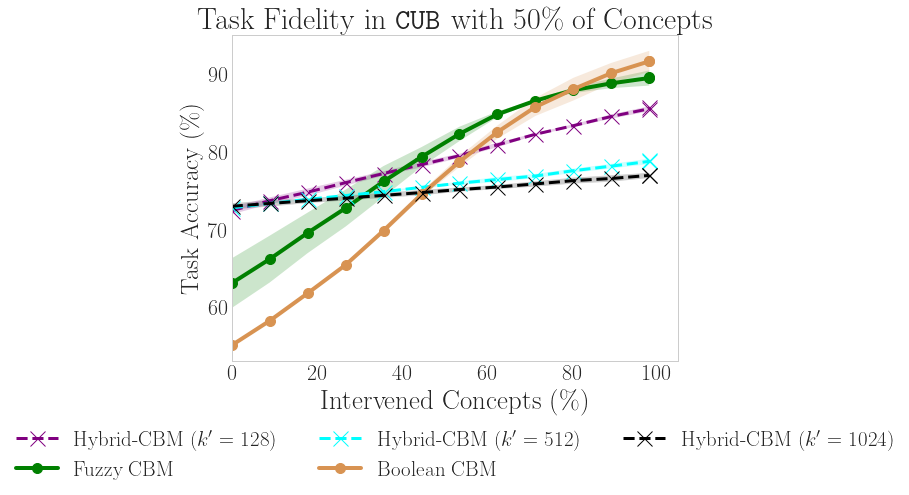

In [75]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percent = 0.5
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    model_name = model_name_template.format(
        sampling_percent=sampling_percent,
        concept_loss_weight=concept_loss_weight,
    )
    vals = get_metric_from_dict(
        results,
        model_name,
        f"test_acc_y_random_group_level_False_use_prior_False_ints",
    )
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=0) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=0) * 100
    xticks = (
        [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
    )
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
    means = np.array(list(means[::freq]) + [means[-1]])
    stds = np.array(list(stds[::freq]) + [stds[-1]])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
# ax.set_ylim(50, 90)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -3)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB} with ' + str(int(sampling_percent * 100)) + "\% of Concepts", fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=3, #len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_interventions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_interventions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.70607525 0.69520193]
 [0.71211598 0.71211598]
 [0.72937522 0.71971004]
 [0.71332413 0.72281671]
 [0.72333448 0.71971004]
 [0.72178115 0.72229893]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [70.06385916 71.21159821 72.45426303 71.80704177 72.15222644 72.20400414]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

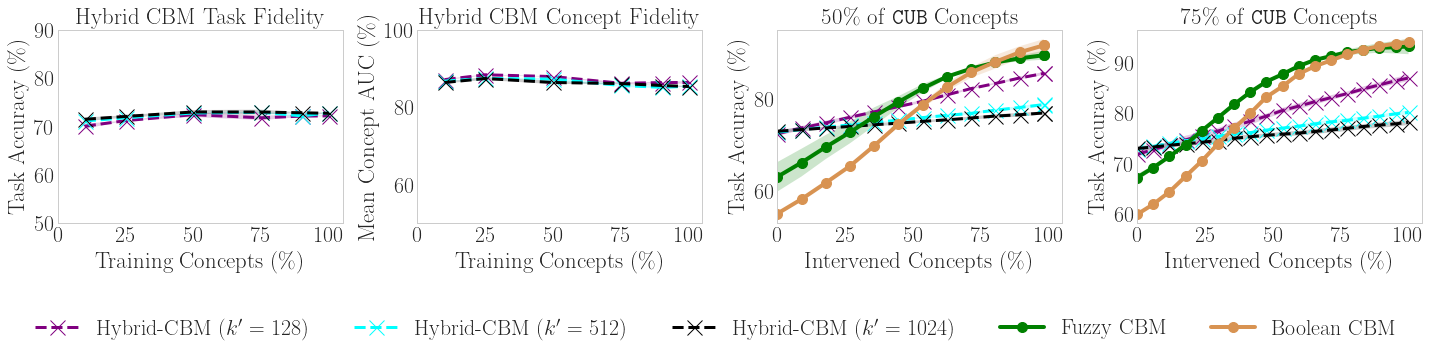

In [97]:
rc('text', usetex=True) # For quality, let's temporarily disable this
sampling_percents = [0.5, 0.75]
results = results_to_include[0]['results']
fig, axs = plt.subplots(1, 4, figsize=(20, 4), squeeze=False)

ax = axs[0, 0]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 90)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
# ax.set_title(r'\texttt{CUB} Task Fidelity', fontsize=23)
ax.set_title(r'Hybrid CBM Task Fidelity', fontsize=23)
ax.grid(False)





ax = axs[0, 1]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Mean Concept AUC (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
# ax.set_title(r'\texttt{CUB} Concept Fidelity', fontsize=23)
ax.set_title(r'Hybrid CBM Concept Fidelity', fontsize=23)
ax.grid(False)












sampling_percents = [0.5, 0.75]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for axis_idx, sampling_percent in enumerate(sampling_percents):
    ax = axs[0, 2 + axis_idx]
    for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        vals = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_False_use_prior_False_ints",
        )
        vals = np.array(vals)
        print("For", label, "we got vals", vals)
        print(vals.shape)
        means = np.mean(vals, axis=0) * 100
        print("For", label, "we got means", means)
        stds = np.std(vals, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if color is None:
            color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        linestyle = '-'
        xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
        means = np.array(list(means[::freq]) + [means[-1]])
        stds = np.array(list(stds[::freq]) + [stds[-1]])
        marker = markers.get(label, "x" if "Hybrid" in label else "o")
        linestyle = '--' if "Hybrid" in label else '-'
        linewidth = 3 if "Hybrid" in label else 4 
        markersize = 15 if "Hybrid" in label else 10 
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=markersize,
            linewidth=linewidth,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_xticks([0, 25, 50, 75, 100])
    # ax.set_ylim(50, 90)
    ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -7)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title(str(int(sampling_percent * 100)) + r"\% of \texttt{CUB} Concepts", fontsize=23)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()



# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+7,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=5, #len(used_baselines_to_include),
)
plt.tight_layout()
plt.savefig(f"../figures/thesis/completeness_ablation_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got vals [[0.17932344 0.19641008]
 [0.47238523 0.47152226]
 [0.66309976 0.59924059]
 [0.67880566 0.66517087]
 [0.65636866 0.7026234 ]
 [0.70797377 0.70538488]]
(6, 2)
For Fuzzy CBM we got means [18.78667587 47.19537453 63.1170176  67.19882637 67.94960304 70.66793234]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got vals [[0.16499827 0.17138419]
 [0.43165343 0.43614084]
 [0.54970659 0.55298585]
 [0.59872282 0.59855022]
 [0.62046945 0.60648947]
 [0.60787021 0.62081464]]
(6, 2)
For Boolean CBM we 

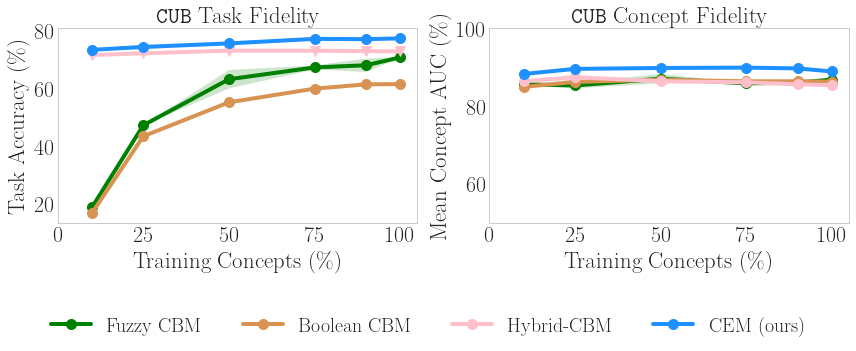

In [111]:
rc('text', usetex=True) # For quality, let's temporarily disable this
results = results_to_include[0]['results']
fig, axs = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)

ax = axs[0, 0]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM', 'pink'),
    ('CEM_sampling_{sampling_percent}_cwl_{concept_loss_weight}', 'CEM (ours)', 'dodgerblue'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    # marker = markers.get(label, "x" if "Hybrid" in label else "o")
    # linestyle = '--' if "Hybrid" in label else '-'
    # linewidth = 3 if "Hybrid" in label else 4 
    # markersize = 15 if "Hybrid" in label else 10
    marker = markers.get(label, "o")
    linestyle = '-'
    linewidth = 4 
    markersize = 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
# ax.set_ylim(50, 90)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'\texttt{CUB} Task Fidelity', fontsize=23)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()





ax = axs[0, 1]
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    # marker = markers.get(label, "x" if "Hybrid" in label else "o")
    # linestyle = '--' if "Hybrid" in label else '-'
    # linewidth = 3 if "Hybrid" in label else 4 
    # markersize = 15 if "Hybrid" in label else 10
    marker = "o" #markers.get(label, "o")
    linestyle = '-'
    linewidth = 4 
    markersize = 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Mean Concept AUC (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'\texttt{CUB} Concept Fidelity', fontsize=23)
handles, labels = ax.get_legend_handles_labels()
ax.grid(False)


# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+5,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=5, #len(used_baselines_to_include),
)
plt.tight_layout()
plt.savefig(f"../figures/thesis/completeness_ablation_cem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_cem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


In [103]:
labels

['Hybrid-CBM ($k^\\prime = 128$)',
 'Hybrid-CBM ($k^\\prime = 512$)',
 'Hybrid-CBM ($k^\\prime = 1024$)']